# Time-Series Forecasting Methods using Darts Library Baseline Models

https://unit8co.github.io/darts/examples.html

# Data

As our dataset we will use the "Carbon-monitor-..." which contains the values of contribution for each sector compared to the total amount of all sectors from 2019-01-01 until 2023-05-31 

In [1]:
import pandas as pd 
import numpy as np

df = pd.read_csv('DataSets /WORLD-OWID-Features-NO_EDA')
df

,year,cement_co2,co2,coal_co2,flaring_co2,gas_co2,oil_co2
0,1750,NaN,9.351,9.351,NaN,NaN,NaN
1,1751,NaN,9.351,9.351,NaN,NaN,NaN
2,1752,NaN,9.354,9.354,NaN,NaN,NaN
3,1753,NaN,9.354,9.354,NaN,NaN,NaN
4,1754,NaN,9.358,9.358,NaN,NaN,NaN
...,...,...,...,...,...,...,...
267,2017,1507.923,36096.738,14506.974,391.992,7144.928,12242.628
268,2018,1569.218,36826.508,14746.831,412.116,7529.847,12266.017
269,2019,1617.507,37082.559,14725.978,439.254,7647.528,12345.653
270,2020,1637.537,35264.086,14174.564,407.584,7556.290,11191.809


Since we are using forecasting models, we will first replace our index with our 'year'

In [2]:
# This will be done later, after formatting our 'year' column to timeformat 

#df.set_index('year', inplace=True) # To create this as a new dataframe -> Index=False

#We will set our 'year' column as index using the darts 'TimeSeries' function

# Installation Darts Library

**Darts** Guide Github: https://unit8co.github.io/darts/quickstart/00-quickstart.html 

In [3]:
#!pip install darts

If while installing 'darts' you have trouble (with lightgbm), here is the documentation: https://lightgbm.readthedocs.io/en/latest/Quick-Start.html

In [4]:
import torch
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler
import logging

logging.disable(logging.CRITICAL)

In [5]:
#!pip install --upgrade notebook

In [6]:
#!pip install --upgrade ipywidgets

# Preprocessing Data 

In [7]:
# df['date'] = pd.to_datetime(df['year'], format='%Y')  # in case of dataset without right date formatting

In [2]:

df['year'] = pd.to_datetime(df['year'], format="%Y")   #,format="%Y-%m-%d")

# Set 'date' column as the index
df.set_index('year', inplace=True)

#df = df.resample('W').sum()  # Grouping and summarizing the data on a weekly base

In [3]:
df = df.astype(np.float32)
df

,cement_co2,co2,coal_co2,flaring_co2,gas_co2,oil_co2
year,,,,,,
1750-01-01,NaN,9.351000,9.351000,NaN,NaN,NaN
1751-01-01,NaN,9.351000,9.351000,NaN,NaN,NaN
1752-01-01,NaN,9.354000,9.354000,NaN,NaN,NaN
1753-01-01,NaN,9.354000,9.354000,NaN,NaN,NaN
1754-01-01,NaN,9.358000,9.358000,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-01-01,1507.922974,36096.738281,14506.973633,391.992004,7144.928223,12242.627930
2018-01-01,1569.218018,36826.507812,14746.831055,412.115997,7529.847168,12266.016602
2019-01-01,1617.506958,37082.558594,14725.977539,439.253998,7647.527832,12345.653320


# Visualizing

There are a lot of visualitzation techniques al clearly explained in the documentation: https://unit8co.github.io/darts/quickstart/00-quickstart.html

<function matplotlib.pyplot.show(close=None, block=None)>

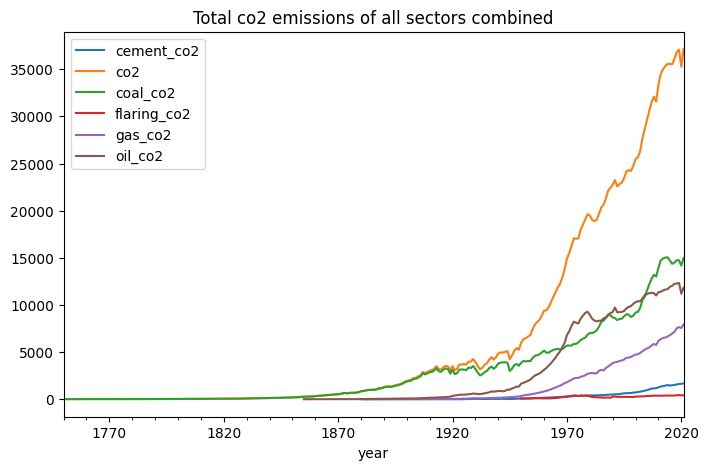

In [4]:
import matplotlib.pyplot as plt

df.plot(figsize=(8,5))
plt.title('Total co2 emissions of all sectors combined')

plt.show

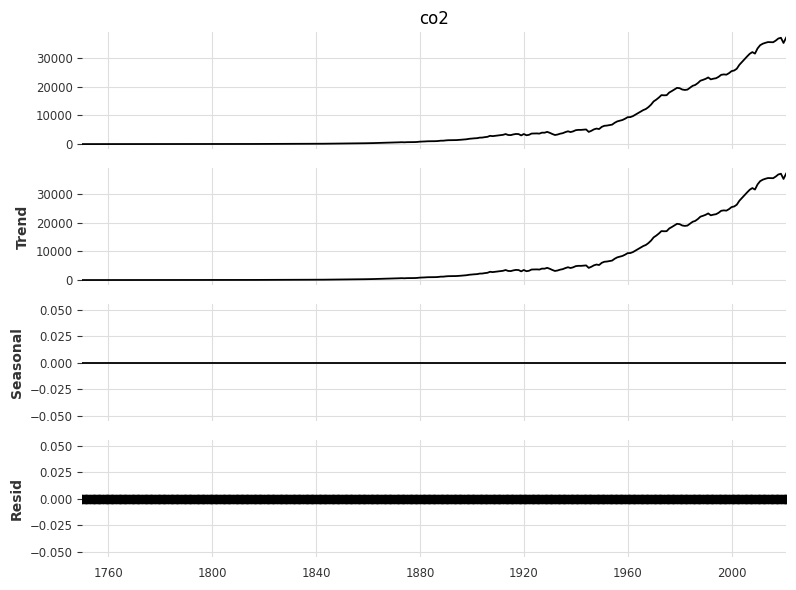

In [11]:
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose

# We can use the seasonal_decompose to get a better view at the trend and seasonality
mpl.rcParams['figure.figsize'] = (8,6)

result = seasonal_decompose(df['co2'])
result.plot()

plt.show()

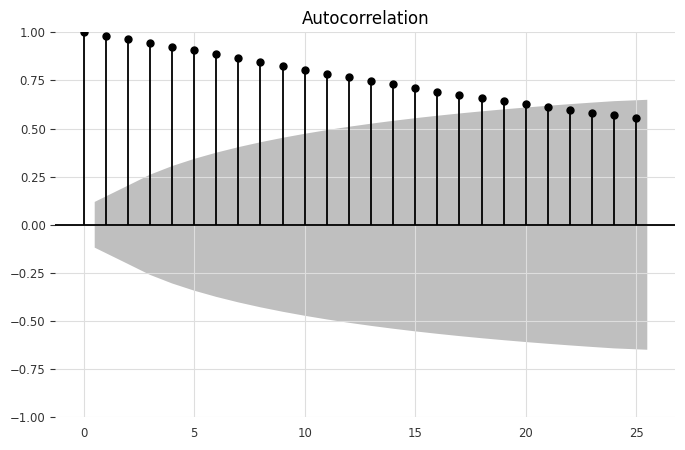

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8,5))

plot_acf(df['co2'], ax = ax)

plt.show()

In [13]:
#series = TimeSeries.from_dataframe(df, 'year', 'co2')


# Splits the series into two parts based on a given split ratio 
#series1, series2 = series.split_before(0.75)
#series1.plot()
#series2.plot()

In [14]:
#series_noise = TimeSeries.from_times_and_values(
    #series.time_index, np.random.randn(len(series))
#)
#(series / 2 + 20 * series_noise - 10).plot()

In [15]:
#series1, series2 = series[:-36], series[-36:]
#series1.plot()
#series2.plot()

# Converting dataset to a Timeseries Object 

In [16]:
#df = df['co2']

In [17]:
from darts import TimeSeries

# Creating a TimeSeries object from the DataFrame

series = TimeSeries.from_dataframe(df)

start = pd.Timestamp('1980-01-01')  # The data from where we will start making prediction 2022-10-01
df_metrics = pd.DataFrame()   # We will "append" our evaluations of each model to a new dataset 

# Backtest and Metrics Helper Functions

In [18]:
from darts.metrics import mae, rmse, mape, smape, r2_score
import matplotlib.pyplot as plt

# actual values of the time series and the forecasted values. Takes in the model chosen

def plot_backtest(series, forecast, model_name):
    idx = -40   # By setting our index to -40 we wille trying to forecast our latest 40 years. 
    series[idx:].plot(label='Actual Values')
    forecast[idx:].plot(label= 'Forecast')
    plt.title(model_name)
    plt.show()

# calculates various evaluation metrics for the forecasted values compared to the actual values

def print_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    mape_ = mape(series, forecast)
    smape_ = smape(series, forecast)  
    r2_score_ = r2_score(series, forecast)

    dict_ = {
        'MAE': mae_,
        'RMSE': rmse_,
        'MAPE': mape_,
        'SMAPE': smape_,
        'R2': r2_score_
    }

    df = pd.DataFrame(dict_, index=[model_name])  

    return df.round(decimals=2)

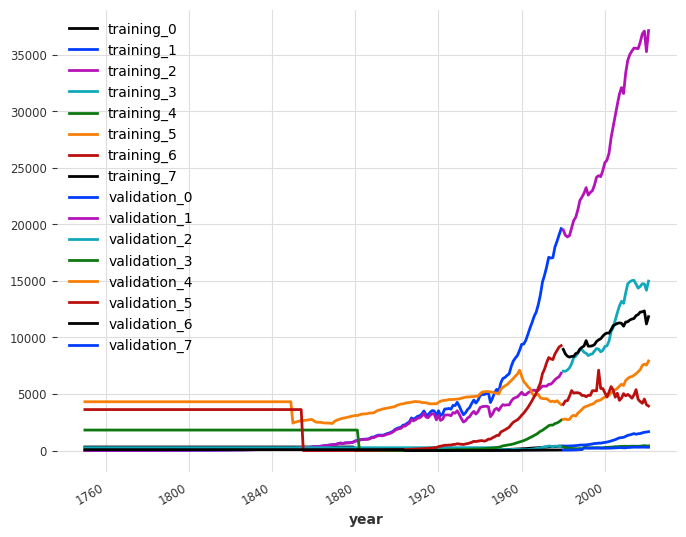

In [19]:
train, val = series.split_before(pd.Timestamp("1980-01-01"))   # Start prediction from this date 
train.plot(label="training")
val.plot(label="validation")

# Creating a Naive Forecasting BaseModel

  0%|          | 0/41 [00:00<?, ?it/s]

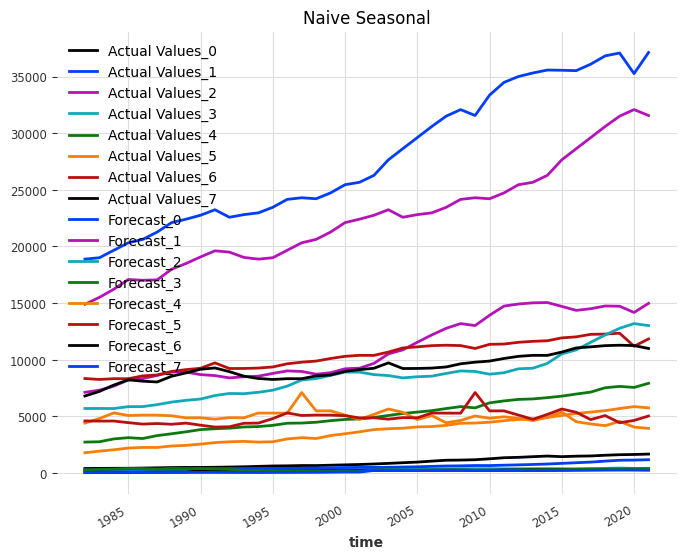

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,1429.209961,1586.390015,24.56,28.14,-0.2


In [20]:
from darts.models import NaiveSeasonal

model = NaiveSeasonal(K = 12)
model_name = 'Naive Seasonal'
model.fit(series)



forecast = model.historical_forecasts(series, start=start, forecast_horizon=2, verbose=True)
plot_backtest(series, forecast, model_name)
df_naive = print_metrics(series, forecast, model_name)
df_metrics = pd.concat([df_metrics, df_naive])

plt.show()
df_naive

# Exponential Smoothening BaseLine Model

This model can only be used with 1 feature, not with multiple features. 

In [21]:
model = ExponentialSmoothing(seasonal_periods = 12)
model_name = 'Exponential Smoothing'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, start=start, forecast_horizon=12, verbose=True)
plot_backtest(df['co2'], forecast, model_name)
df_exp = print_metrics(series, forecast, model_name)
df_metrics = pd.concat([df_metrics, df_exp])

plt.show()
df_exp

  0%|          | 0/31 [00:00<?, ?it/s]

ValueError: Model `ExponentialSmoothing` only supports univariate TimeSeries instances

<Figure size 800x500 with 0 Axes>

In [ ]:
model = ExponentialSmoothing(seasonal_periods = 20)
model_name = 'Exponential Smoothing'

model.fit(series)
forecast = model.predict(20)

plot_backtest(series, forecast, model_name)
print(forecast.pd_dataframe())

In [22]:
use_cuda = torch.cuda.is_available()
PYTORCH_ENABLE_MPS_FALLBACK=1

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    dropout=0.2,
    dilation_base=3,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=28,
)

if use_cuda:
    model.cuda()
model_name = 'TCN'

plt.figure(figsize = (8, 5))

scaler = Scaler()
scaled_series = scaler.fit_transform(series)
forecast = model.historical_forecasts(scaled_series, start=start,
                                      forecast_horizon=12, verbose=True)
plot_backtest(series, scaler.inverse_transform(forecast), model_name)
df_dl = print_metrics(series, scaler.inverse_transform(forecast), model_name)
df_metrics = df_metrics.append(df_dl)

plt.show()
df_dl

  0%|          | 0/31 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

NotImplementedError: The operator 'aten::_weight_norm_interface' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

<Figure size 800x500 with 0 Axes>